## EDA

In [ ]:
# Importing Libraries

#!pip install lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import lightgbm as lgb

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.width",700)
warnings.filterwarnings("ignore")

In [ ]:
# Loading Dataset

data = pd.read_csv("/content/iyzico_data.csv", parse_dates = ["transaction_date"])
df = data.copy()
df.drop("Unnamed: 0", axis=1,inplace=True)
df

transaction_date  merchant_id  Total_Transaction  Total_Paid
0          2018-01-01          535                349   25883.226
1          2018-01-01        42616                141   40918.860
2          2018-01-01        46774                410  306902.700
3          2018-01-01        86302                 10      11.340
4          2018-01-01       124381                285  111383.766
...               ...          ...                ...         ...
7662       2020-12-31        46774               3394 3174751.332
7663       2020-12-31        57192                856  337696.020
7664       2020-12-31        86302               2657   10461.006
7665       2020-12-31       124381               3668 2445655.950
7666       2020-12-31       129316                485    2101.050

[7667 rows x 4 columns]

In [ ]:
def check_df(dataframe, head = 5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    numeric_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["int32","int64","float32","float64"]]
    print(dataframe[numeric_cols].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

##################### Shape #####################
(7667, 4)
##################### Types #####################
transaction_date     datetime64[ns]
merchant_id                   int64
Total_Transaction             int64
Total_Paid                  float64
dtype: object
##################### Head #####################
  transaction_date  merchant_id  Total_Transaction  Total_Paid
0       2018-01-01          535                349   25883.226
1       2018-01-01        42616                141   40918.860
2       2018-01-01        46774                410  306902.700
3       2018-01-01        86302                 10      11.340
4       2018-01-01       124381                285  111383.766
##################### Tail #####################
     transaction_date  merchant_id  Total_Transaction  Total_Paid
7662       2020-12-31        46774               3394 3174751.332
7663       2020-12-31        57192                856  337696.020
7664       2020-12-31        86302               2657   10

Quantiles

- The median for Total_Transaction is 815, but the maximum value is 34,617. This most likely indicates that some traders are executing a lot more transactions than others and there are some outliers.
- There is a similar situation for Total_Paid. The median value is around 186,434 TL, while the maximum is as large as 12 million TL. This shows that some transactions are extremely large.
- Both Total_Transaction and Total_Paid show very large outliers. The jumps at 99% and 100% are particularly striking. It may be worthwhile to investigate these outliers in more detail, looking for reasons for the extreme values for certain traders or dates.
- Some traders are much more active than others. For example, the number of trades and payout amounts for traders in the 95% bracket are quite different from those in the less active 50% bracket.

In [ ]:
# Checking start and end date
print("Start Date:", df["transaction_date"].min(),"\n", "End Date:", df["transaction_date"].max())

Start Date: 2018-01-01 00:00:00 
 End Date: 2020-12-31 00:00:00


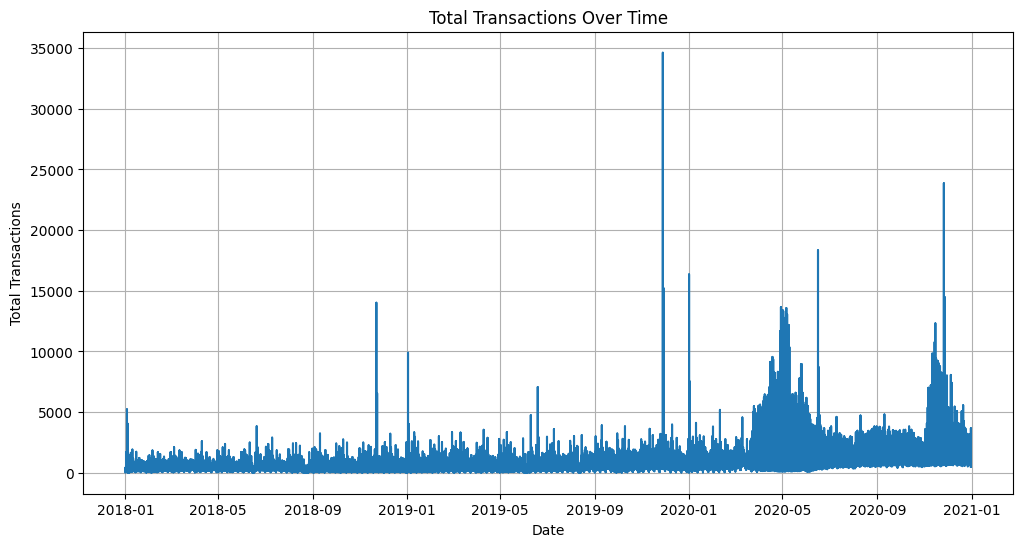

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df["transaction_date"], df["Total_Transaction"])
plt.title("Total Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Total Transactions")
plt.grid()
plt.show()

In [ ]:
df.groupby(["merchant_id"]).agg({"Total_Transaction": "sum"})

Total_Transaction
merchant_id                   
535                    1302725
42616                  1126191
46774                  1599559
57192                  1146440
86302                   840951
124381                 1935357
129316                  440029

In [ ]:
df.groupby(["merchant_id"]).agg({"Total_Paid": "sum"})

Total_Paid
merchant_id               
535          156601530.234
42616        354583091.808
46774       1567200341.286
57192        317337137.586
86302          2870446.716
124381      1158692543.973
129316         1555471.476

In [ ]:
df["merchant_id"].unique()

array([   535,  42616,  46774,  86302, 124381, 129316,  57192])

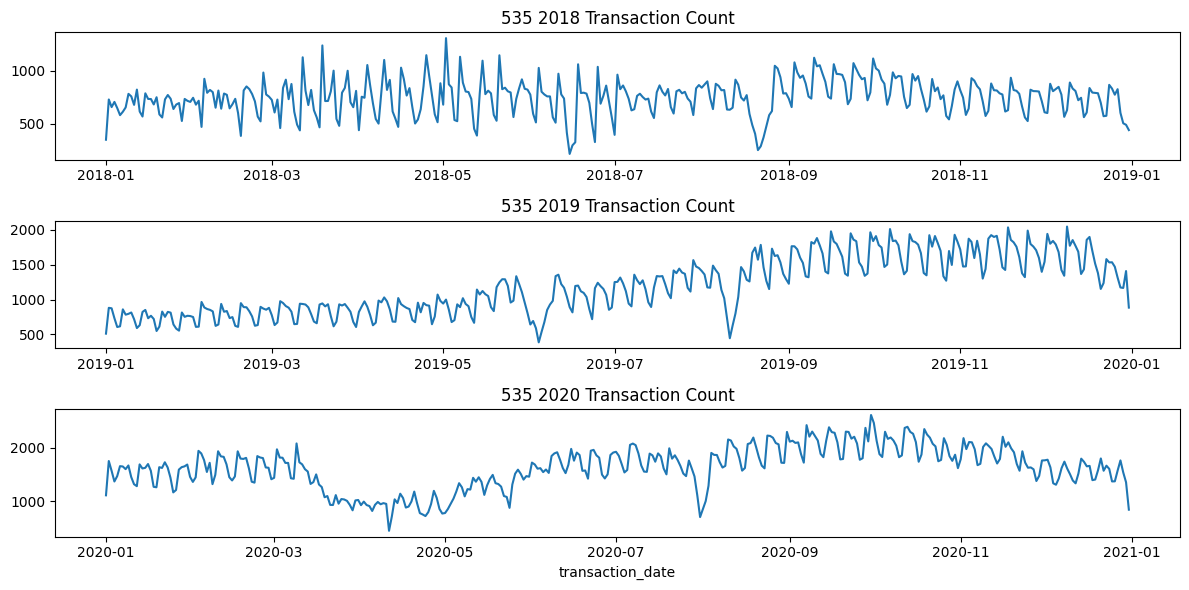

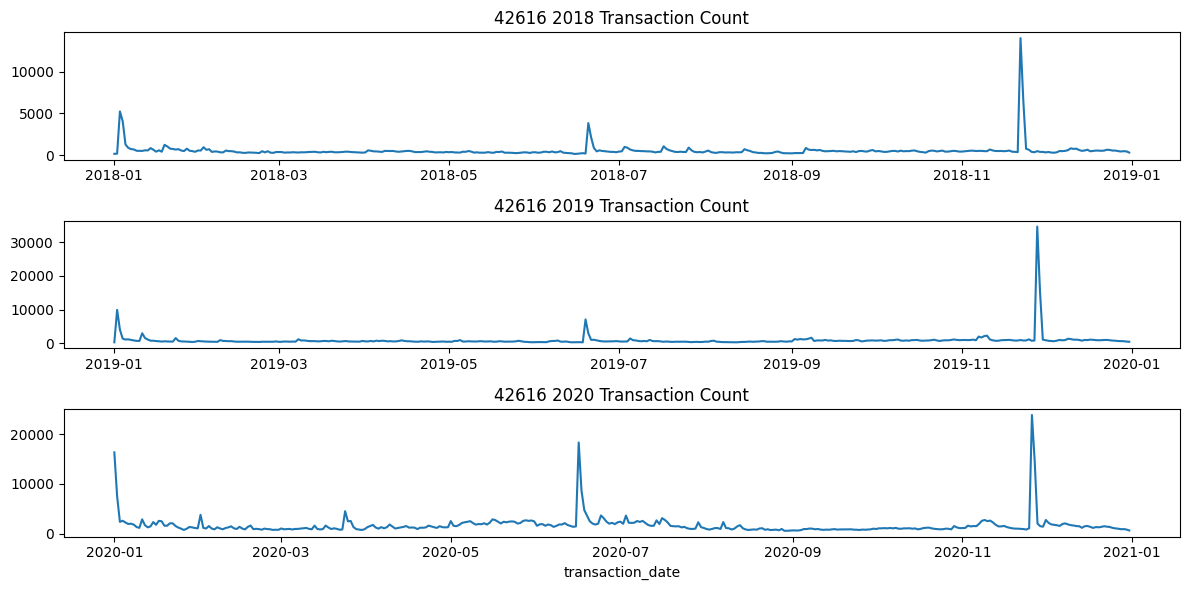

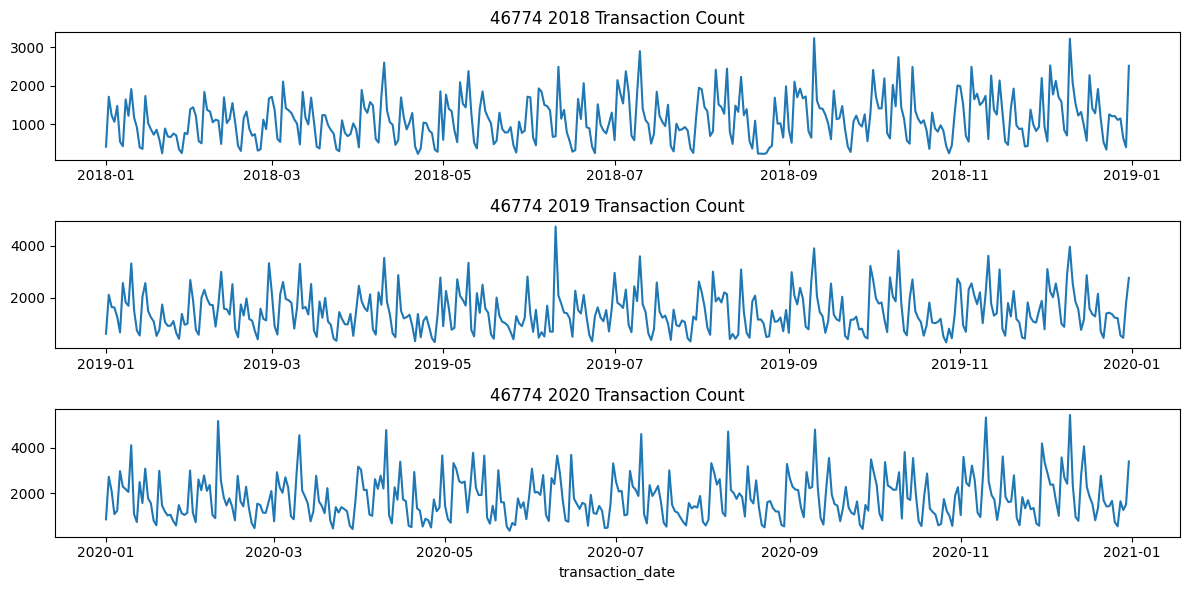

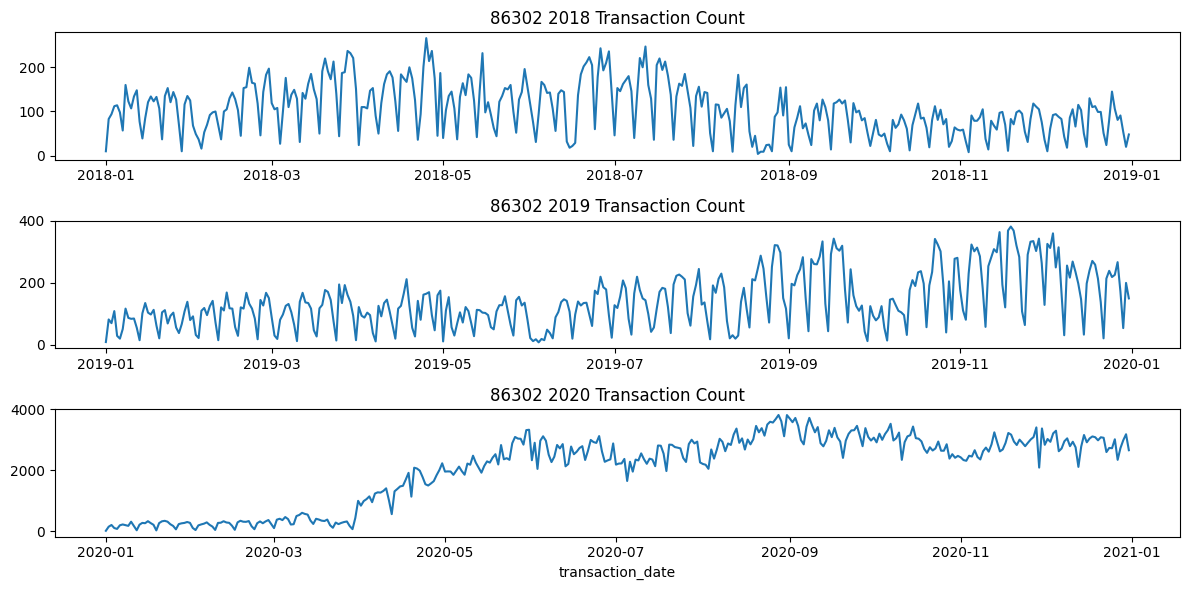

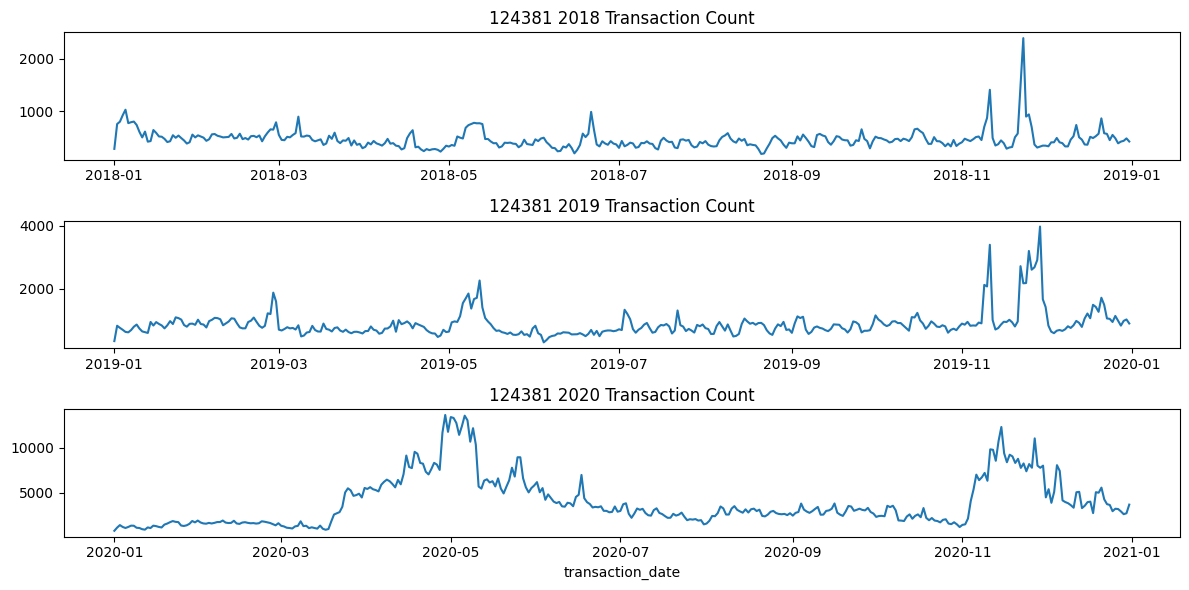

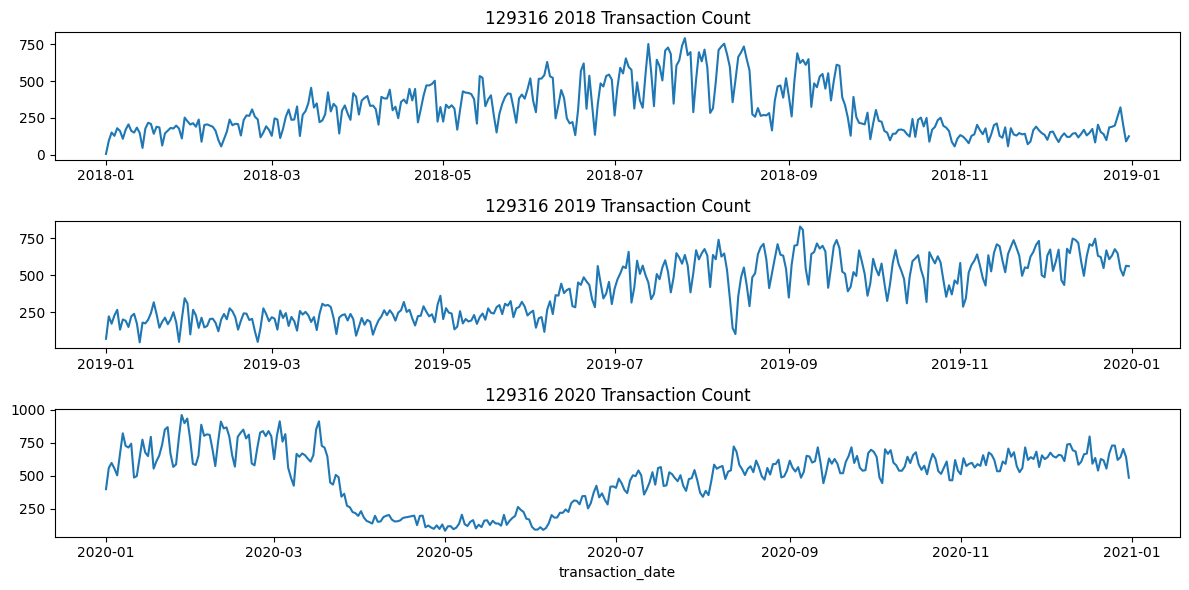

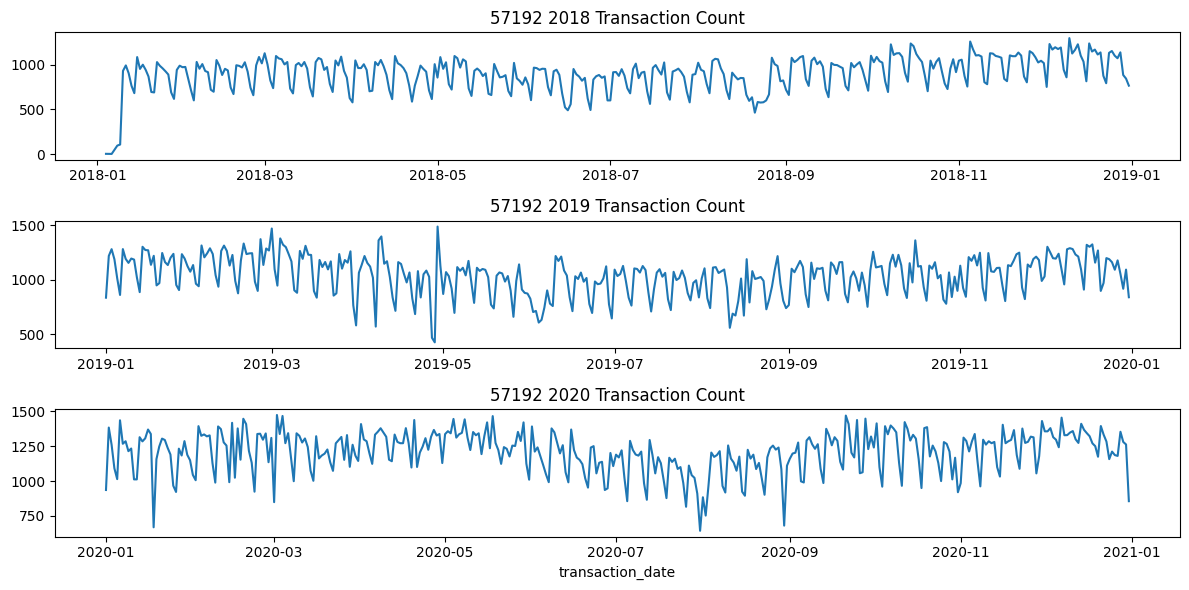

In [ ]:
for id in df["merchant_id"].unique():
    # Plot for 2018
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1, title=f'{id} 2018 Transaction Count')
    df_2018 = df[(df.merchant_id == id) & (df.transaction_date >= "2018-01-01") & (df.transaction_date < "2019-01-01")]
    df_2018.groupby(df_2018["transaction_date"].dt.date)["Total_Transaction"].sum().plot()
    plt.xlabel('')  # Remove x-axis label for cleaner display

    # Plot for 2019
    plt.subplot(3, 1, 2, title=f'{id} 2019 Transaction Count')
    df_2019 = df[(df.merchant_id == id) & (df.transaction_date >= "2019-01-01") & (df.transaction_date < "2020-01-01")]
    df_2019.groupby(df_2019["transaction_date"].dt.date)["Total_Transaction"].sum().plot()
    plt.xlabel('')  # Remove x-axis label for cleaner display

    # Optional: add a third plot for 2020 if needed
    plt.subplot(3, 1, 3, title=f'{id} 2020 Transaction Count')
    df_2020 = df[(df.merchant_id == id) & (df.transaction_date >= "2020-01-01") & (df.transaction_date < "2021-01-01")]
    df_2020.groupby(df_2020["transaction_date"].dt.date)["Total_Transaction"].sum().plot()

    plt.tight_layout()
    plt.show()

-------

## Feature Engineering

In [ ]:
def create_features(dataframe, lags, windows, alphas):

    # Creating Date Features
    dataframe["year"] = dataframe["transaction_date"].dt.year
    dataframe["month"] = dataframe["transaction_date"].dt.month
    dataframe["day"] = dataframe["transaction_date"].dt.day
    dataframe["week_of_year"] = dataframe["transaction_date"].dt.isocalendar().week
    dataframe["day_of_week"] = dataframe["transaction_date"].dt.dayofweek
    dataframe["day_of_year"] = dataframe["transaction_date"].dt.dayofyear
    dataframe["is_weekend"] = dataframe["transaction_date"].dt.weekday // 4
    dataframe["is_month_start"] = dataframe["transaction_date"].dt.is_month_start.astype(int)
    dataframe["is_month_end"] = dataframe["transaction_date"].dt.is_month_end.astype(int)
    dataframe["is_quarter_start"] = dataframe["transaction_date"].dt.is_quarter_start.astype(int)
    dataframe["is_quarter_end"] = dataframe["transaction_date"].dt.is_quarter_end.astype(int)
    dataframe["is_year_start"] = dataframe["transaction_date"].dt.is_year_start.astype(int)
    dataframe["is_year_end"] = dataframe["transaction_date"].dt.is_year_end.astype(int)
    dataframe["is_black_friday"] = 0
    dataframe.loc[dataframe["transaction_date"].isin(["2018-11-22","2018-11-23","2019-11-29","2019-11-30"]) ,"is_black_friday"]= 1
    df["is_summer_solstice"] = 0
    dataframe.loc[dataframe["transaction_date"].isin(["2018-11-22","2018-11-23","2019-11-29","2019-11-30"]) ,"is_summer_solstice"]= 1
    dataframe["is_christmas"] = 0
    dataframe.loc[dataframe["transaction_date"].isin(["2018-12-24","2018-12-25","2018-12-26","2019-12-24","2019-12-25","2019-12-26"]) ,"is_christmas"]= 1
    dataframe["is_halloween"] = 0
    dataframe.loc[dataframe["transaction_date"].isin(["2018-10-31","2019-10-31"]) ,"is_halloween"] = 1
    dataframe["is_pascalya"] = 0
    dataframe.loc[dataframe["transaction_date"].isin(["2018-04-01","2019-04-21"]) ,"is_pascalya"] = 1
    dataframe["is_eid"] = 0
    dataframe.loc[dataframe["transaction_date"].isin(["2018-06-14","2018-06-15","2018-06-16", "2018-06-04", "2018-06-05", "2018-06-06"]) ,"is_eid"] = 1

    #lags = [i for i in range(91, 727, 3)]

    # Creating Lag/Shifted Features + Adding Noise
    for lag in lags:
        dataframe["total_transaction_lag_" + str(lag)] = dataframe.groupby(["merchant_id"])["Total_Transaction"]\
            .transform(lambda x: x.shift(lag)) + np.random.normal(loc=0, scale=1.5, size=len(dataframe))

    # Creating Rolling Mean Features + Adding Noise
    for window in windows:
        dataframe["total_transaction_roll_" + str(window)] = dataframe.groupby(["merchant_id"])["Total_Transaction"]\
            .transform(lambda x: x.shift(1).rolling(window=window).mean()) + np.random.normal(loc=0, scale=1.5, size=len(dataframe))

    #alphas = [.99, .95, .90, .85, .80, .70, .65, .50, .35, .15, 0.1, .01]

    # Creating Exponentially Weighted Features
    for alpha in alphas:
        for lag in lags:
            dataframe["total_transaction_ewf_" + str(alpha).replace(".", "") + "_lag_" + str(lag)] = dataframe.groupby(["merchant_id"])["Total_Transaction"]\
                .transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())

    return dataframe


In [ ]:
lags = [i for i in range(91, 727, 3)]
windows = [i for i in range(30, 727, 30)]
alphas = [.99, .95, .90, .85, .80, .70, .65, .50, .35, .15, 0.1, .01]

df = create_features(df, lags, windows, alphas)

In [ ]:
check_df(df)

##################### Shape #####################
(7667, 2803)
##################### Types #####################
transaction_date                     datetime64[ns]
merchant_id                                   int64
Total_Transaction                             int64
Total_Paid                                  float64
year                                          int32
                                          ...      
total_transaction_ewf_001_lag_712           float64
total_transaction_ewf_001_lag_715           float64
total_transaction_ewf_001_lag_718           float64
total_transaction_ewf_001_lag_721           float64
total_transaction_ewf_001_lag_724           float64
Length: 2803, dtype: object
##################### Head #####################
  transaction_date  merchant_id  Total_Transaction  Total_Paid  year  month  day  week_of_year  day_of_week  day_of_year  is_weekend  is_month_start  is_month_end  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_black_fri

------

## One-Hot Encoding

In [ ]:
df = pd.get_dummies(df, columns=["merchant_id", "day_of_week", "month"])
df

transaction_date  Total_Transaction  Total_Paid  year  day  week_of_year  day_of_year  is_weekend  is_month_start  is_month_end  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_black_friday  is_summer_solstice  is_christmas  is_halloween  is_pascalya  is_eid  total_transaction_lag_91  total_transaction_lag_94  total_transaction_lag_97  total_transaction_lag_100  total_transaction_lag_103  total_transaction_lag_106  total_transaction_lag_109  total_transaction_lag_112  total_transaction_lag_115  total_transaction_lag_118  total_transaction_lag_121  total_transaction_lag_124  total_transaction_lag_127  total_transaction_lag_130  total_transaction_lag_133  \
0          2018-01-01                349   25883.226  2018    1             1            1           0               1             0                 1               0              1            0                0                   0             0             0            0       0                       NaN                       NaN                       NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN   
1          2018-01-01                141   40918.860  2018    1             1            1           0               1             0                 1               0              1            0                0                   0             0             0            0       0                       NaN                       NaN                       NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN   
2          2018-01-01                410  306902.700  2018    1             1            1           0               1             0                 1               0              1            0                0                   0             0             0            0       0                       NaN                       NaN                       NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN   
3          2018-01-01                 10      11.340  2018    1             1            1           0               1             0                 1               0              1            0                0                   0             0             0            0       0                       NaN                       NaN                       NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN   
4          2018-01-01                285  111383.766  2018    1             1            1           0               1             0                 1               0              1            0                0                   0             0             0            0       0                       NaN                       NaN                       NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN 

-----

## Log of Dependent Variable

In [ ]:
df["Total_Transaction"] = np.log1p(df["Total_Transaction"].values)
df

transaction_date  Total_Transaction  Total_Paid  year  day  week_of_year  day_of_year  is_weekend  is_month_start  is_month_end  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_black_friday  is_summer_solstice  is_christmas  is_halloween  is_pascalya  is_eid  total_transaction_lag_91  total_transaction_lag_94  total_transaction_lag_97  total_transaction_lag_100  total_transaction_lag_103  total_transaction_lag_106  total_transaction_lag_109  total_transaction_lag_112  total_transaction_lag_115  total_transaction_lag_118  total_transaction_lag_121  total_transaction_lag_124  total_transaction_lag_127  total_transaction_lag_130  total_transaction_lag_133  \
0          2018-01-01              5.858   25883.226  2018    1             1            1           0               1             0                 1               0              1            0                0                   0             0             0            0       0                       NaN                       NaN                       NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN   
1          2018-01-01              4.956   40918.860  2018    1             1            1           0               1             0                 1               0              1            0                0                   0             0             0            0       0                       NaN                       NaN                       NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN   
2          2018-01-01              6.019  306902.700  2018    1             1            1           0               1             0                 1               0              1            0                0                   0             0             0            0       0                       NaN                       NaN                       NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN   
3          2018-01-01              2.398      11.340  2018    1             1            1           0               1             0                 1               0              1            0                0                   0             0             0            0       0                       NaN                       NaN                       NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN   
4          2018-01-01              5.656  111383.766  2018    1             1            1           0               1             0                 1               0              1            0                0                   0             0             0            0       0                       NaN                       NaN                       NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN 

------

## Custom Cost Function

In [ ]:
def smape(preds, targets):
    n = len(preds)
    masked_arr = ~((preds == 0) & (targets == 0))
    preds, target = preds[masked_arr], targets[masked_arr]
    num = np.abs(preds - targets)
    denom = np.abs(preds) + np.abs(targets)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [ ]:
def lgbm_smape(preds, train_data):
  labels = train_data.get_label()
  smape_val = smape(preds, labels)
  return 'SMAPE', smape_val, False

----

## Time Based Validation Sets

In [ ]:
# train set
train = df.loc[(df["transaction_date"] < "2020-10-01"),:]

# validation set
val = df.loc[(df["transaction_date"] >= "2020-10-01") & (df["transaction_date"] <= "2020-12-31" ),:]

# independent features
cols = [col for col in train.columns if col not in ["transaction_date", "merchant_id", "Total_Paid", "Total_Transaction", "year"]]

Y_train = train["Total_Transaction"]
X_train = train[cols]

Y_val = val["Total_Transaction"]
X_val = val[cols]

In [ ]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((7023,), (7023, 2822), (644,), (644, 2822))

----

## Building Model

In [ ]:
# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:
lgbtrain = lgb.Dataset(data = X_train, label = Y_train, feature_name = cols)
lgbval = lgb.Dataset(data = X_val, label = Y_val, reference = lgbtrain, feature_name = cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets = [lgbtrain, lgbval],
                  feval = lgbm_smape, # lost function
                  num_boost_round = lgb_params['num_boost_round'],
                  callbacks = [lgb.early_stopping(stopping_rounds=lgb_params['early_stopping_rounds']), lgb.log_evaluation(100)])

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.16166	training's SMAPE: 4.49104	valid_1's l2: 0.169404	valid_1's SMAPE: 3.57472
[200]	training's l2: 0.109053	training's SMAPE: 3.56642	valid_1's l2: 0.126245	valid_1's SMAPE: 2.98319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's l2: 0.091697	training's SMAPE: 3.25224	valid_1's l2: 0.127248	valid_1's SMAPE: 2.9841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

21.8258733068457

-----

## Feature Importance

In [ ]:
def plot_lgb_importance(model, plot = False, num = 10):
  gain = model.feature_importance('gain')
  feat_imp = pd.DataFrame({'feature': model.feature_name(),
                          ' split': model.feature_importance('split'),
                            'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
  if plot:
      plt.figure(figsize=(10, 10))
      sns.set(font_scale=1)
      sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
      plt.title('feature')
      plt.tight_layout()
      plt.show()
  else:
      print(feat_imp.head(num))
  return feat_imp

In [ ]:
plot_lgb_importance(model, num = 3000)

                                feature   split   gain
228           total_transaction_roll_30     403 64.456
229           total_transaction_roll_60      61 15.328
2809                      day_of_week_6     114  2.102
2800                  merchant_id_86302      73  1.962
252    total_transaction_ewf_099_lag_91      20  0.884
...                                 ...     ...    ...
1037  total_transaction_ewf_085_lag_538       0  0.000
1038  total_transaction_ewf_085_lag_541       0  0.000
1039  total_transaction_ewf_085_lag_544       0  0.000
1040  total_transaction_ewf_085_lag_547       0  0.000
2821                           month_12       0  0.000

[2822 rows x 3 columns]


feature   split   gain
228           total_transaction_roll_30     403 64.456
229           total_transaction_roll_60      61 15.328
2809                      day_of_week_6     114  2.102
2800                  merchant_id_86302      73  1.962
252    total_transaction_ewf_099_lag_91      20  0.884
...                                 ...     ...    ...
1037  total_transaction_ewf_085_lag_538       0  0.000
1038  total_transaction_ewf_085_lag_541       0  0.000
1039  total_transaction_ewf_085_lag_544       0  0.000
1040  total_transaction_ewf_085_lag_547       0  0.000
2821                           month_12       0  0.000

[2822 rows x 3 columns]

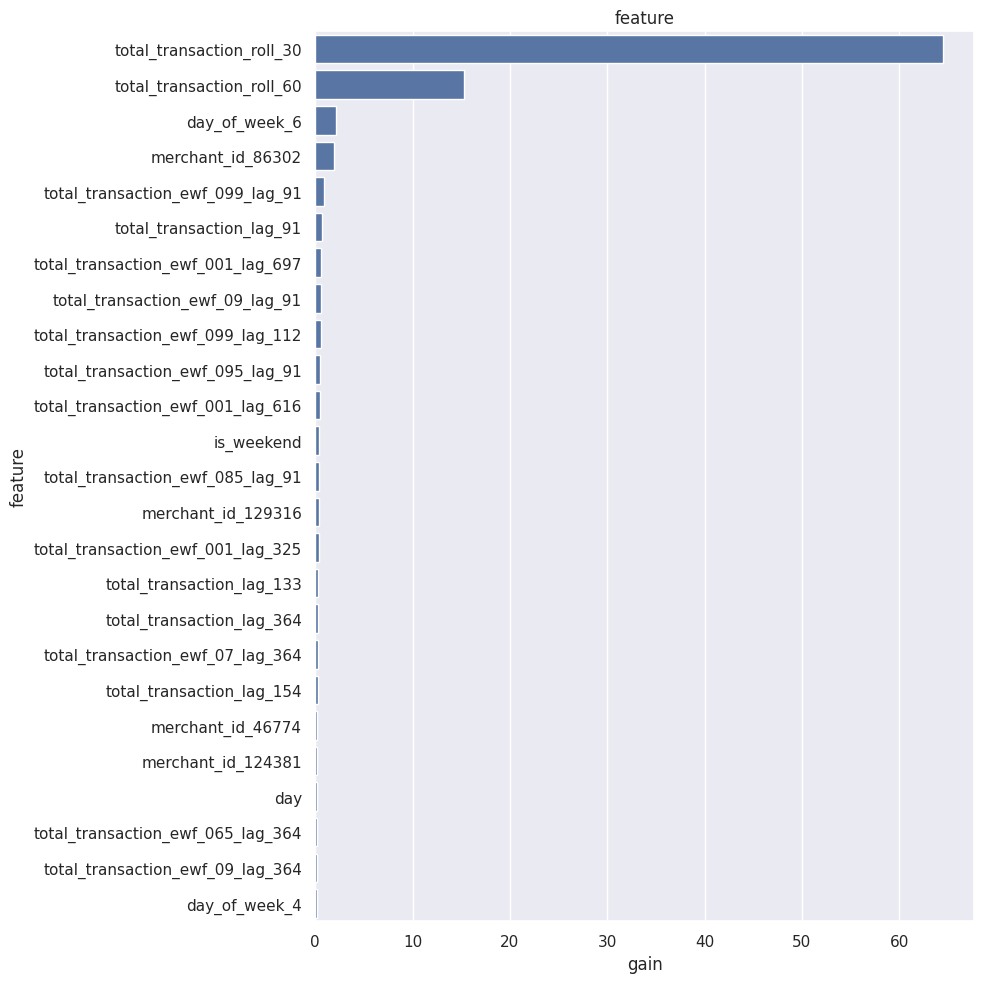

feature   split   gain
228           total_transaction_roll_30     403 64.456
229           total_transaction_roll_60      61 15.328
2809                      day_of_week_6     114  2.102
2800                  merchant_id_86302      73  1.962
252    total_transaction_ewf_099_lag_91      20  0.884
...                                 ...     ...    ...
1037  total_transaction_ewf_085_lag_538       0  0.000
1038  total_transaction_ewf_085_lag_541       0  0.000
1039  total_transaction_ewf_085_lag_544       0  0.000
1040  total_transaction_ewf_085_lag_547       0  0.000
2821                           month_12       0  0.000

[2822 rows x 3 columns]

In [ ]:
plot_lgb_importance(model, num=30, plot=True)

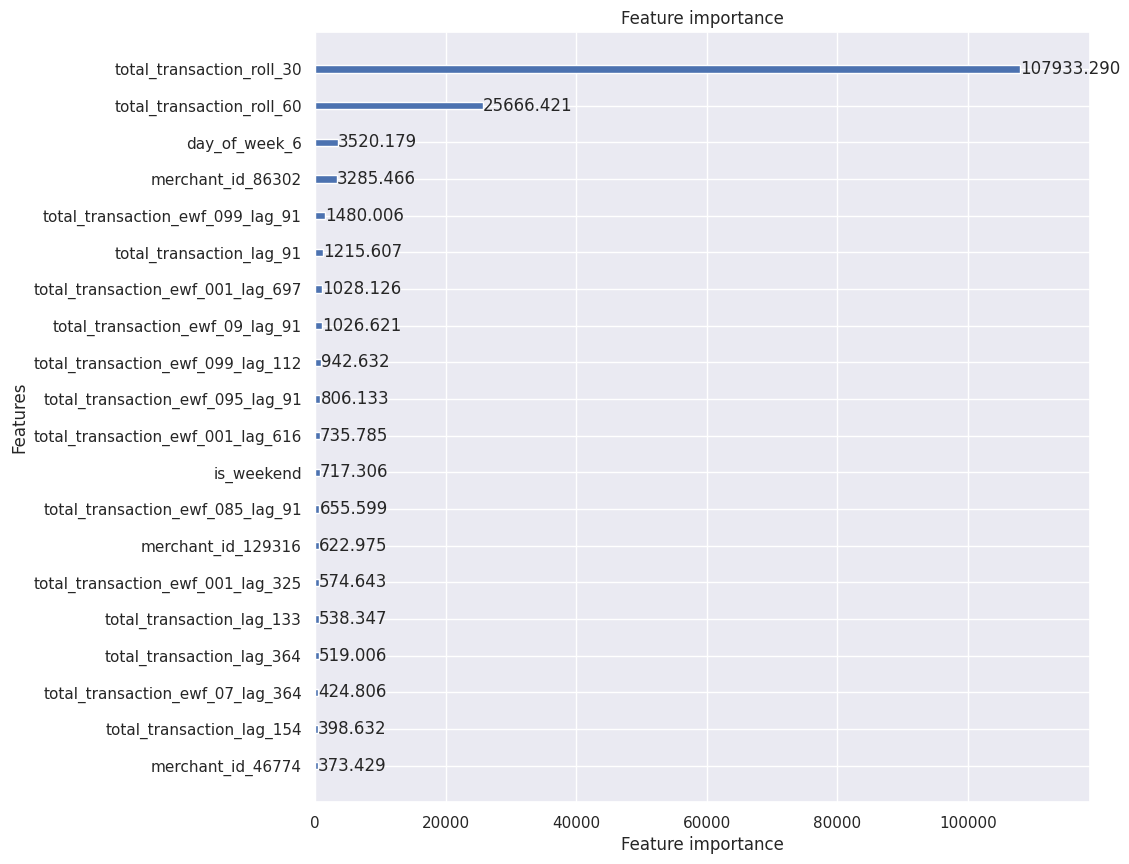

In [ ]:
lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

In [ ]:
# Getting low impact features.

feat_imp = plot_lgb_importance(model, num = 3000)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

                                feature   split   gain
228           total_transaction_roll_30     403 64.456
229           total_transaction_roll_60      61 15.328
2809                      day_of_week_6     114  2.102
2800                  merchant_id_86302      73  1.962
252    total_transaction_ewf_099_lag_91      20  0.884
...                                 ...     ...    ...
1037  total_transaction_ewf_085_lag_538       0  0.000
1038  total_transaction_ewf_085_lag_541       0  0.000
1039  total_transaction_ewf_085_lag_544       0  0.000
1040  total_transaction_ewf_085_lag_547       0  0.000
2821                           month_12       0  0.000

[2822 rows x 3 columns]


573

-----

## Predicting with The Best Iteration

In [ ]:
y_pred_val = model.predict(X_val, num_iteration = model.best_iteration)

In [ ]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

21.8258733068457

----

## Final Model

In [ ]:
# Using entire dataset in order to create train ve val sets
train = df.loc[(df["transaction_date"] <= "2020-12-31"), :]
val = df.loc[(df["transaction_date"] <= "2020-12-31"), :]

# Dependent and Independent variables
Y_train = train["Total_Transaction"]
X_train = train[cols]

Y_val = val["Total_Transaction"]
X_val = val[cols]

# LightGBM model
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  feval=lgbm_smape,
                  num_boost_round=lgb_params['num_boost_round'],
                  callbacks=[lgb.early_stopping(stopping_rounds=lgb_params['early_stopping_rounds']),
                             lgb.log_evaluation(100)])

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.159538	training's SMAPE: 4.37755	valid_1's l2: 0.159538	valid_1's SMAPE: 4.37755
[200]	training's l2: 0.107456	training's SMAPE: 3.48193	valid_1's l2: 0.107456	valid_1's SMAPE: 3.48193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

-------

## Predicting Future Transactions

In [ ]:
train = df.loc[df["transaction_date"] <= "2020-12-31", :]

Y_train = train["Total_Transaction"]
X_train = train[cols]

# Create LightGBM dataset
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols, free_raw_data=False)

# Model parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}


final_model = lgb.train(lgb_params,
                       lgbtrain,
                       valid_sets=[lgbtrain],
                       feval=lgbm_smape,
                       num_boost_round=lgb_params['num_boost_round'],
                       callbacks=[lgb.early_stopping(stopping_rounds=lgb_params['early_stopping_rounds']),
                                  lgb.log_evaluation(100)])



future_dates = pd.date_range(start='2021-01-01', end='2021-03-31')

# Orijinal merchant kolonları (one-hot encoded)
merchant_columns = [col for col in df.columns if col.startswith('merchant_id_')]
unique_merchants = [col.replace('merchant_id_', '') for col in merchant_columns]

future_predictions_list = []

for merchant in unique_merchants:
    # for each merchant create dataframe
    future_df = pd.DataFrame({'transaction_date': future_dates})
    future_df['merchant_id'] = merchant  # Merchant ID ekle

    # Initialize 'Total_Transaction' column with 0
    # This is necessary for the create_features function to work
    future_df['Total_Transaction'] = 0

    # create features
    future_df = create_features(future_df, lags, windows, alphas)

    # One-hot encoding
    future_df = pd.get_dummies(future_df, columns=["merchant_id", "day_of_week", "month"])


    missing_cols = set(X_train.columns) - set(future_df.columns)
    for col in missing_cols:
        future_df[col] = 0
    future_df = future_df[X_train.columns]

    # Predict
    predictions = final_model.predict(future_df[cols], num_iteration=final_model.best_iteration)

    # Log dönüşümünü geri al
    predictions = np.expm1(predictions)

    # add results to dataframe
    result_df = pd.DataFrame({
        'transaction_date': future_dates,
        'merchant': merchant,
        'predicted_transactions': predictions
    })



Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.158744	training's SMAPE: 4.36299
[200]	training's l2: 0.106761	training's SMAPE: 3.47285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's l2: 0.0899114	training's SMAPE: 3.18607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [ ]:
 result_df

transaction_date merchant  predicted_transactions
0        2021-01-01   129316                 142.221
1        2021-01-02   129316                 178.959
2        2021-01-03   129316                 162.204
3        2021-01-04   129316                 198.996
4        2021-01-05   129316                 208.223
..              ...      ...                     ...
85       2021-03-27   129316                 109.002
86       2021-03-28   129316                  65.919
87       2021-03-29   129316                 127.849
88       2021-03-30   129316                 127.849
89       2021-03-31   129316                 130.160

[90 rows x 3 columns]

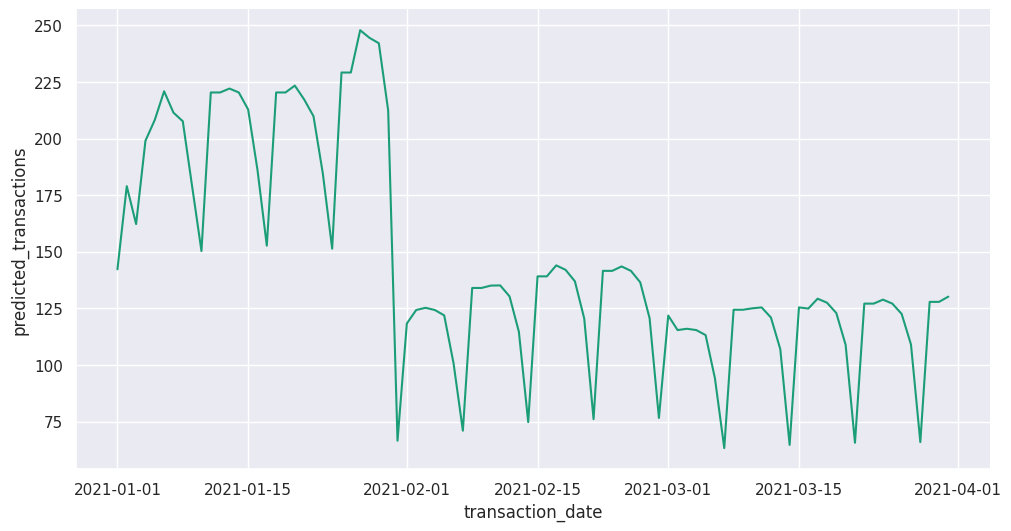

In [ ]:
# @title transaction_date vs predicted_transactions

from matplotlib import pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['transaction_date']
  ys = series['predicted_transactions']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = result_df.sort_values('transaction_date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('transaction_date')
_ = plt.ylabel('predicted_transactions')